In [1]:
import numpy as np
import awkward as ak
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

import utils as pic

%load_ext autoreload
%autoreload 2

In [2]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU

In [3]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [4]:
X_train.shape

(2048, 32, 32, 2)

In [5]:
X_train = pic.remove_empty_pixels(X_train)
X_train.shape

(2048, 32, 32, 2)

In [6]:
# pic.plot_spacetime(X_train,y_train,1024)

In [7]:
# for i in range(10):
#     pic.plot_event(X_train,y_train,i)
#     pic.plot_event(X_train,y_train,-1-i)


In [8]:
X_e_timeordered,X_t_timeordered = pic.timeordered(X_train,cumulative=False)

In [23]:
import matplotlib.animation as animation
%matplotlib qt
fig,ax = plt.subplots()


def plot_timestep(timestep,time,iframe):
    im = ax.imshow(timestep,animated=True)
    return [im,ax.text(1,1,f"Frame: {iframe} | Time: {time:.3}")]

frames = [ plot_timestep(timestep,time,iframe) for iframe,(timestep,time) in enumerate(zip(X_e_timeordered[0],X_t_timeordered[0])) if np.any(~np.isnan(timestep)) ]
ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True)
plt.show()

In [10]:
timing = np.sort(X_train.reshape(-1,32*32,2)[:,:,1],axis=-1)

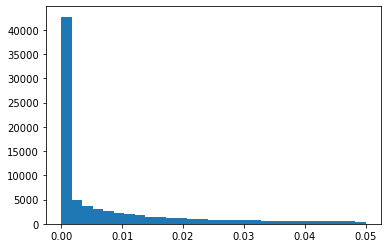

In [11]:
%matplotlib inline
plt.hist( (timing[:,1:] - timing[:,:-1]).flatten(),bins=np.linspace(0,0.05,30) );

In [12]:
a = np.sort(np.array([[1, 0, 0, 2, 2], [1, 0, 0, 0, 3], [2, 3, 4, 5, 5]]),axis=-1)
a

array([[0, 0, 1, 2, 2],
       [0, 0, 0, 1, 3],
       [2, 3, 4, 5, 5]])

In [13]:
dup_runs = ak.run_lengths(a.flatten())
mask = ak.unflatten(ak.sum(dup_runs)*[False],dup_runs)
mask = ak.flatten(ak.concatenate([~mask[:,0,None],mask[:,1:]],axis=-1)).to_numpy().reshape(a.shape)
a_sorted = np.sort(np.where(mask,a,np.nan),axis=-1)